## 1  Imports and configuration

In [1]:

import os, glob, json, re, joblib, numpy as np, pandas as pd
from pathlib import Path
from typing import List, Dict
from tqdm import tqdm
# install pyarrow if Parquet needed
from pathlib import Path
import pandas as pd, joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import google.generativeai as genai, os, time
from google.api_core import retry, exceptions


with open('../env.json', 'r') as f:
    env_vars = json.load(f)
    
os.environ["GOOGLE_API_KEY"] = env_vars["GOOGLE_API_KEY"]

#env.json
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

model = genai.GenerativeModel("gemini-2.0-flash")

model.generate_content = retry.Retry(predicate=lambda e: hasattr(e, 'code') and e.code in {429, 503})(model.generate_content)

/Users/main/Desktop/Personal/Active/oneprompted/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2  Train (or load) the logistic‑regression rubric model

In [2]:
MODEL_FILE = Path("train_logreg.joblib")
DATA_FILE  = Path("../data/Prompt_Training_2.0/cleaned_labeled_train.csv")

if MODEL_FILE.exists():
    # load the already‐trained model
    bundle = joblib.load(MODEL_FILE)
    tfidf, clf = bundle['tfidf'], bundle['clf']
else:
    # load your dual‐column CSV
    df_raw = pd.read_csv(DATA_FILE)

    # original prompts = label 0 (bad)
    neg = (
      df_raw[['original_prompt']]
        .rename(columns={'original_prompt':'text'})
        .assign(label=0)
    )
    # improved prompts = label 1 (good)
    pos = (
      df_raw[['cleaned_improved_prompt']]
        .rename(columns={'cleaned_improved_prompt':'text'})
        .assign(label=1)
    )
    # combine into one training set
    df_train = pd.concat([neg, pos], ignore_index=True)
    
    # train TF‑IDF + LogReg
    tfidf = TfidfVectorizer(min_df=3, ngram_range=(1,2))
    X = tfidf.fit_transform(df_train['text'])
    clf = LogisticRegression(max_iter=2000).fit(X, df_train['label'])
    
    # save for future runs
    joblib.dump({'tfidf': tfidf, 'clf': clf}, MODEL_FILE)


## 3  Embedding helper (optional semantic guard)

In [3]:

# ↓ Replace with your own embedding backend (OpenAI, Gemini, HF, etc.)
def get_embedding(text:str):
    raise NotImplementedError("Plug in your embedding API call here")

def cosine(a,b):
    a,b=np.array(a),np.array(b)
    return float(np.dot(a,b)/(np.linalg.norm(a)+1e-9)/(np.linalg.norm(b)+1e-9))

def semantic_ok(orig:str, cand:str, threshold:float=0.85)->bool:
    try:
        return cosine(get_embedding(orig), get_embedding(cand)) >= threshold
    except NotImplementedError:
        # If you haven't wired embeddings yet, skip the semantic check.
        return True


## 4  Load model CSVs

In [4]:

CSV_DIR = Path('../data')   # change if needed
FILE_MAP = {                               # filename → user‑friendly tag
    'BaseModelResponses/responses.csv'   : 'none',
    'FineTunedV1Responses/responses.csv': 'v1',
    'FineTunedV2Responses/responses.csv': 'v2',
    'NoModelResponses/responses.csv'     : 'base',
}

frames = []
for fname, tag in FILE_MAP.items():
    path = CSV_DIR / fname
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path)[['original_prompt', 'response']].copy()
    df = df.rename(columns={'response': f'resp_{tag}'})
    frames.append(df)

# Outer‑merge on original_prompt so we keep prompts that appear in any file
base = frames[0]
for f in frames[1:]:
    base = base.merge(f, on='original_prompt', how='outer')

df_merged = base
print('Merged shape:', df_merged.shape)
df_merged.head()

Merged shape: (1418, 5)


,original_prompt,resp_none,resp_v1,resp_v2,resp_base
0,\tYou are a prompt generation machine. You are...,"Okay, here are my goals for this prompt genera...","Okay, here's a detailed prompt designed to eli...","Alright, let's get started! Hi there! I'm your...","Alright, let's get started! So, tell me, what ..."
1,\n You can summarize the contents of th...,Here's a summary of the key findings and insig...,"Okay, I've analyzed the usability testing resu...","Okay, here's a concise UX analysis summary bas...","Okay, I've analyzed the Notion page you provid..."
2,"\nCan the OpenAI API ""Davinci"" mode when comb...","Okay, let's outline the Python code and the ov...","Okay, I understand. Please provide me with the...","Okay, let's analyze GPT-3's Davinci model for ...","Yes, the OpenAI API with the Davinci model (or..."
3,"\nCreate a Google Apps Addon, which will first...",```javascript\n/**\n * Google Calendar Add-on ...,"Okay, let's break down the process of creating...",```javascript\n/**\n * Google Calendar Add-on ...,"Okay, this is a more complex project, but let'..."
4,\nExplain the moon landing to a 6 year old in ...,"Okay, imagine a giant rocket ship, super tall ...","Okay, imagine a giant ball of rock in the sky ...","Hey there, space cadet! Long ago, brave astron...",Imagine the Earth is like your house and the M...


## 5  Evaluate each response

In [5]:
# ── One‑time train & dump ──
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

df_raw = pd.read_csv("../data/Prompt_Training_2.0/cleaned_labeled_train.csv")
neg = df_raw[["original_prompt"]].rename(columns={"original_prompt":"text"}).assign(label=0)
pos = df_raw[["cleaned_improved_prompt"]].rename(columns={"cleaned_improved_prompt":"text"}).assign(label=1)
df_train = pd.concat([neg, pos], ignore_index=True)

tfidf = TfidfVectorizer(min_df=3, ngram_range=(1,2))
X = tfidf.fit_transform(df_train["text"])
clf = LogisticRegression(max_iter=2000).fit(X, df_train["label"])

joblib.dump({"tfidf":tfidf, "clf":clf}, MODEL_FILE)
print("Trained & saved", MODEL_FILE)


Trained & saved train_logreg.joblib


In [6]:
# ── Load your trained TF‑IDF + LogisticRegression rubric model ──
import joblib
from pathlib import Path

MODEL_FILE = Path("train_logreg.joblib")
if not MODEL_FILE.exists():
    raise FileNotFoundError(f"{MODEL_FILE} not found — run your training cell first.")

bundle = joblib.load(MODEL_FILE)
tfidf, clf = bundle["tfidf"], bundle["clf"]

def grade_prompt_logreg(prompt: str) -> float:
    """
    Returns the probability that 'prompt' is a 'good' prompt,
    as learned from your labeled prompt vs improved_prompt data.
    """
    vec = tfidf.transform([prompt])        # shape (1, n_features)
    return float(clf.predict_proba(vec)[0, 1])


In [7]:
variant_cols = [c for c in df_merged.columns if c.startswith('resp_')]
results = []

for _, row in tqdm(df_merged.iterrows(), total=len(df_merged)):
    orig = row['original_prompt']
    for col in variant_cols:
        cand = row[col]
        if pd.isna(cand):
            continue
        # optional: drop if it drifts semantically
        if not semantic_ok(orig, cand):
            continue
        score = grade_prompt_logreg(cand)
        results.append({
            'original_prompt': orig,
            'model': col.replace('resp_', ''),
            'score': score
        })

results_df = pd.DataFrame(results)
print('Scored', len(results_df), 'prompt‑variant pairs')
results_df.head()


100%|██████████| 1418/1418 [00:03<00:00, 447.75it/s]

Scored 5672 prompt‑variant pairs


,original_prompt,model,score
0,\tYou are a prompt generation machine. You are...,none,0.660604
1,\tYou are a prompt generation machine. You are...,v1,0.851595
2,\tYou are a prompt generation machine. You are...,v2,0.091254
3,\tYou are a prompt generation machine. You are...,base,0.048184
4,\n You can summarize the contents of th...,none,0.814194


## 6  Aggregate & save

In [8]:
agg = (
    results_df
    .groupby('model')['score']
    .agg(['mean','count'])
    .sort_values('mean', ascending=False)
)
print(agg)

#  ▶ choose the best model per prompt
best_by_prompt = (
    results_df
    .sort_values('score', ascending=False)
    .drop_duplicates('original_prompt')    # use prompt instead of conversation_id
    .rename(columns={'score':'best_score'})
)
best_by_prompt['rank'] = 1                  # every retained row is the #1 pick
best_by_prompt = best_by_prompt[
    ['original_prompt','model','best_score','rank']
]
print("\nBest variant per prompt:")
display(best_by_prompt.head())

#  ▶ write out full scored table
results_df.to_csv('../data/PromptEval/prompt_eval_scores.csv', index=False)
print('\nSaved scores → prompt_eval_scores.csv')

           mean  count
model                 
v1     0.501744   1418
v2     0.474198   1418
none   0.473070   1418
base   0.411917   1418

Best variant per prompt:


,original_prompt,model,best_score,rank
3990,Write a detailed outline for a definitive guid...,v2,0.986789,1
4600,describe 10 critical points of adhesive materi...,none,0.971293,1
165,2 / 2Is there any articles or studies about re...,v1,0.971140,1
42,!Please outline the steps to build an automate...,v2,0.964598,1
274,Act as a Business Analyst to gather the requir...,v2,0.961799,1



Saved scores → prompt_eval_scores.csv


In [9]:
# ── Rubric evaluator (uses your existing `model`) ──
import json

rubric_instructions = '''
***STRICT FORMAT INSTRUCTIONS***  
Your response **must** be **only** a single JSON object matching exactly the schema below.  
Do **NOT** include any prose, bullet points, headings, or explanation outside the JSON.  
If you cannot comply, return an empty JSON object `{}`.

Schema:
{
  "task_category": "<Informational|Creative|Technical|Problem-solving|Analytical>",
  "relevance": 1,
  "accuracy": 1,
  "completeness": 1,
  "clarity": 1,
  "creativity": 1,
  "conciseness": 1,
  "technical_correctness": 1,
  "actionability": 1,
  "weighted_score": 0.0
}

Calculations:
- Informational: relevance*0.25 + accuracy*0.3 + completeness*0.2 + clarity*0.15 + conciseness*0.1  
- Creative:      relevance*0.2 + completeness*0.15 + clarity*0.15 + creativity*0.4 + conciseness*0.1  
- Technical:     relevance*0.15 + accuracy*0.2 + completeness*0.15 + clarity*0.15 + technical_correctness*0.25 + actionability*0.1  
- Problem-solving: relevance*0.2 + accuracy*0.15 + completeness*0.15 + clarity*0.1 + actionability*0.4  
- Analytical:    relevance*0.2 + accuracy*0.25 + completeness*0.2 + clarity*0.15 + creativity*0.2  

Example output:
{
  "task_category": "Technical",
  "relevance": 5,
  "accuracy": 4,
  "completeness": 5,
  "clarity": 4,
  "creativity": 3,
  "conciseness": 4,
  "technical_correctness": 5,
  "actionability": 5,
  "weighted_score": 4.6
}
'''


def evaluate_with_rubric(prompt: str,
                         response: str,
                         pause: float = 0.2) -> dict:
    payload = f"""{rubric_instructions}

Prompt:
{prompt}

Model Response:
{response}
"""
    try:
        out = model.generate_content(payload)
        text = out.text.strip()
        # Print raw for debugging (once)
        # print("RAW RUBRIC REPLY:", text[:200])

        # Find the first {...} in the output
        m = re.search(r'\{[\s\S]*?\}', text)
        if not m:
            # no JSON found at all
            return {}
        raw = m.group()
        return json.loads(raw)

    except exceptions.GoogleAPICallError as e:
        print("Gemini API error:", e)
        return {}
    except json.JSONDecodeError as e:
        print("Failed to parse JSON:", raw, e)
        return {}
    finally:
        time.sleep(pause)

In [10]:
rubric_rows = []
for _, r in tqdm(results_df.head(50).iterrows(), total=50):
    orig = r['original_prompt']
    tag  = r['model']
    cand = df_merged.loc[df_merged['original_prompt']==orig, f"resp_{tag}"].iloc[0]
    rubric_json = evaluate_with_rubric(orig, cand)

    if not rubric_json:
        continue
    flat = {
        'prompt': orig,
        'model':  tag,
        'lr_score': r['score'],
        'rubric_score': rubric_json.get('weighted_score'),
        **{k: rubric_json.get(k) for k in [
            'task_category','relevance','accuracy','completeness',
            'clarity','creativity','conciseness',
            'technical_correctness','actionability'
        ]}
    }
    rubric_rows.append(flat)

rubric_df = pd.DataFrame(rubric_rows)
print("Sample means by model:")
print(rubric_df.groupby('model')['rubric_score'].mean())


 20%|██        | 10/50 [00:11<00:42,  1.07s/it]

Failed to parse JSON: {
  "task_category": "Analytical",
  "relevance": 5,
  "accuracy": 4,
  "completeness": 5,
  "clarity": 5,
  "creativity": 4,
  "conciseness": 4,
  "technical_correctness": 4,
  "actionability": 4,
  "weighted_score": 4.4,
} Expecting property name enclosed in double quotes: line 12 column 1 (char 223)


 42%|████▏     | 21/50 [01:10<02:08,  4.45s/it]

Failed to parse JSON: {
  "task_category": "Technical",
  "relevance": 5,
  "accuracy": 5,
  "completeness": 5,
  "clarity": 5,
  "creativity": 4,
  "conciseness": 4,
  "technical_correctness": 5,
  "actionability": 5,
  "weighted_score": 4.8,
} Expecting property name enclosed in double quotes: line 12 column 1 (char 222)


 48%|████▊     | 24/50 [01:15<01:10,  2.72s/it]

Failed to parse JSON: {
  "task_category": "Creative",
  "relevance": 5,
  "accuracy": 5,
  "completeness": 5,
  "clarity": 5,
  "creativity": 5,
  "conciseness": 5,
  "technical_correctness": 5,
  "actionability": 5,
  "weighted_score": 4.9,
} Expecting property name enclosed in double quotes: line 12 column 1 (char 221)


100%|██████████| 50/50 [03:02<00:00,  3.65s/it]

Sample means by model:
model
base    3.637500
none    4.116667
v1      3.570833
v2      4.354545
Name: rubric_score, dtype: float64


In [11]:
results_df.to_csv('../data/PromptEval/newRubric.csv', index=False)

In [12]:
from tqdm import tqdm

sample_df = df_merged.sample(n=50, random_state=42).reset_index(drop=True)


def score_response(prompt: str, response: str) -> float:
    """
    Uses the enhanced Gemini rubric to score a model's response.
    Falls back to 0.0 if missing or malformed.
    """
    rubric = evaluate_with_rubric(prompt, response)
    return float(rubric.get("weighted_score", 0.0))

variant_cols = [c for c in sample_df.columns if c.startswith("resp_")]
response_scores = []

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    orig = row["original_prompt"]
    for col in variant_cols:
        cand = row[col]
        if pd.isna(cand):
            continue
        # optional: drop if it drifts too much in meaning
        if not semantic_ok(orig, cand):
            continue
        response_scores.append({
            "original_prompt": orig,
            "model": col.replace("resp_", ""),
            "score": score_response(orig, cand)
        })

responses_sample_df = pd.DataFrame(response_scores)
print("Scored sample of", len(responses_sample_df), "response‑variant pairs")
responses_sample_df.head()

output_path = "../data/responses_sample_scores.csv"
responses_sample_df.to_csv(output_path, index=False)
print(f"Saved sample scores → {output_path}")

 18%|█▊        | 9/50 [02:57<18:35, 27.20s/it]

Failed to parse JSON: {
  "task_category": "Technical",
  "relevance": 5,
  "accuracy": 5,
  "completeness": 5,
  "clarity": 5,
  "creativity": 4,
  "conciseness": 3,
  "technical_correctness": 5,
  "actionability": 5,
  "weighted_score": 4.6,
} Expecting property name enclosed in double quotes: line 12 column 1 (char 222)


 48%|████▊     | 24/50 [06:13<05:05, 11.74s/it]

Failed to parse JSON: {
  "task_category": "Problem-solving",
  "relevance": 5,
  "accuracy": 5,
  "completeness": 5,
  "clarity": 5,
  "creativity": 3,
  "conciseness": 4,
  "technical_correctness": 5,
  "actionability": 5,
  "weighted_score": 4.8,
} Expecting property name enclosed in double quotes: line 12 column 1 (char 228)


100%|██████████| 50/50 [13:26<00:00, 16.13s/it]

Scored sample of 200 response‑variant pairs
Saved sample scores → responses_sample_scores.csv


| Model   |   Regression |   Full Rubric |   Sample Rubric |
|:--------|-------------:|--------------:|----------------:|
| none    |     0.680789 |      0.779167 |        0.7983   |
| v1      |     1        |      0.642708 |        0.82275  |
| v2      |     0.693337 |      0.838636 |        0.887375 |
| base    |     0        |      0.659375 |        0.89175  |


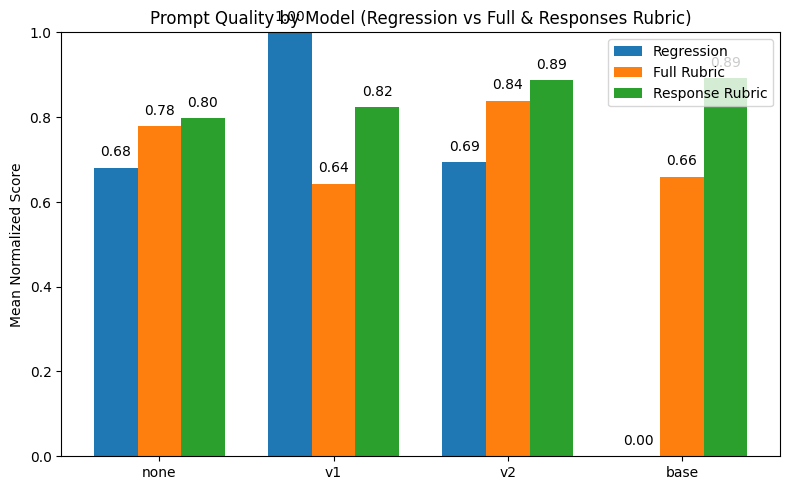

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ── 1) Compute mean by model ──
reg_means    = results_df         .groupby('model')['score'].mean()
full_rub_means = rubric_df       .groupby('model')['rubric_score'].mean()
sample_means = responses_sample_df.groupby('model')['score'].mean()

# ── 2) Normalize all to [0,1] ──
# Regression: min→0, max→1
rmin, rmax    = reg_means.min(), reg_means.max()
reg_norm      = (reg_means - rmin) / (rmax - rmin)
# Rubrics: (value−1)/4 maps [1–5]→[0–1]
full_norm     = (full_rub_means - 1) / 4
sample_norm   = (sample_means   - 1) / 4

# ── 3) Build a summary table ──
models = ['none','v1','v2','base']
df_summary = pd.DataFrame({
    'Regression':    reg_norm.reindex(models),
    'Full Rubric':   full_norm.reindex(models),
    'Sample Rubric': sample_norm.reindex(models),
}, index=models)
df_summary.index.name = 'Model'

# print the table
print(df_summary.to_markdown())

# ── 4) Plot grouped bar chart ──
x     = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width, df_summary['Regression'],    width, label='Regression')
bars2 = ax.bar(x,       df_summary['Full Rubric'],   width, label='Full Rubric')
bars3 = ax.bar(x + width, df_summary['Sample Rubric'], width, label='Response Rubric')

# annotate each bar
for bar in list(bars1) + list(bars2) + list(bars3):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            h + 0.02,
            f"{h:.2f}",
            ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0,1)
ax.set_ylabel('Mean Normalized Score')
ax.set_title('Prompt Quality by Model (Regression vs Full & Responses Rubric)')
ax.legend()

plt.tight_layout()
plt.show()


## Embedding Function

In [14]:
from time import sleep


sample_df = df_merged.sample(n=200, random_state=42).reset_index(drop=True)
variant_cols = [c for c in sample_df.columns if c.startswith("resp_")]

texts = set(sample_df["original_prompt"])
for col in variant_cols:
    texts.update(sample_df[col].dropna())
texts = list(texts)
print(f"Embedding {len(texts)} unique texts via single‑item calls…")

def embed_text(text: str):
    try:
        resp = genai.embed_content(
            model="models/embedding-001",
            content=text,
            task_type="RETRIEVAL_DOCUMENT"
        )
        # for single input, API returns 'embedding'
        if "embedding" in resp:
            return np.array(resp["embedding"])
        if "embeddings" in resp:
            blob = resp["embeddings"][0]
            return np.array(blob.values if hasattr(blob, "values") else blob["values"])
        print("⚠️ No embedding key for:", text[:40])
        return None
    except Exception as e:
        print("🔗 Embed error:", e)
        return None
    finally:
        sleep(0.1)  # throttle

emb_dict = {}
for txt in texts:
    vec = embed_text(txt)
    if vec is not None:
        emb_dict[txt] = vec
print("Got embeddings for", len(emb_dict), "texts")

# Calculates how similar the two input vectors are (cosine similarity)
def cosine(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9))

for col in variant_cols:
    sim_col = f"sim_{col}"
    sample_df[sim_col] = [
        cosine(emb_dict[o], emb_dict[c])
        if o in emb_dict and c in emb_dict else np.nan
        for o, c in zip(sample_df["original_prompt"], sample_df[col])
    ]

sim_cols = [f"sim_{c}" for c in variant_cols]
print(sample_df[sim_cols].describe())

Embedding 725 unique texts via single‑item calls…
Got embeddings for 725 texts
       sim_resp_none  sim_resp_v1  sim_resp_v2  sim_resp_base
count     200.000000   200.000000   200.000000     200.000000
mean        0.785224     0.754607     0.774721       0.793580
std         0.065612     0.076967     0.070496       0.076031
min         0.609376     0.547691     0.640596       0.622869
25%         0.747537     0.701969     0.724036       0.715255
50%         0.773035     0.770866     0.770829       0.797111
75%         0.833030     0.802122     0.839088       0.858329
max         0.955708     0.923265     0.926801       0.940599


In [18]:
from time import sleep
from google.api_core.retry import Retry

def is_retryable(exc):
    return hasattr(exc, "code") and exc.code in {429, 503}

retry_policy = Retry(
    predicate=is_retryable,
    initial=1.0,    # 1s back‑off
    maximum=60.0,   # up to 60s
    multiplier=2.0, # exponential back‑off
    deadline=300.0  # give up after 5 min
)


model.generate_content = retry_policy(model.generate_content)


MINUTE  = 60
ALLOWED = 15
delay   = MINUTE / ALLOWED  # → 4.0 seconds


pairs = [
    (variant_cols[i], variant_cols[j])
    for i in range(len(variant_cols))
    for j in range(i + 1, len(variant_cols))
]


sampled_df = df_merged.sample(n=200, random_state=42)
results = []

for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Pairwise eval"):
    prompt = row['original_prompt']
    for col_a, col_b in pairs:
        resp_a, resp_b = row[col_a], row[col_b]
        prompt_text = (
            "You are an AI evaluator that compares responses.\n\n"
            f"Prompt: {prompt}\n\n"
            f"Response A: {resp_a}\n\n"
            f"Response B: {resp_b}\n\n"
            "Which response is better? Reply with 'A' or 'B'."
        )

        try:
            response = model.generate_content(prompt_text)
            choice = response.text.strip().upper()
        except Exception as e:
            print(f"Error generating comparison: {e}")
            choice = "ERROR"

        results.append({
            'original_prompt': prompt,
            'variant_a': col_a,
            'variant_b': col_b,
            'choice': choice,
        })

        # throttle to ≤15 requests/minute
        sleep(delay)


pairwise_results = pd.DataFrame(results)
pairwise_results.to_csv('pairwise_results.csv', index=False)


pairwise_results.head()


Pairwise eval:  51%|█████     | 102/200 [48:46<2:19:07, 85.18s/it]

Error generating comparison: 504 Deadline Exceeded


Pairwise eval:  72%|███████▏  | 143/200 [1:38:10<3:06:10, 195.97s/it]

Error generating comparison: 504 Deadline Exceeded
Error generating comparison: 504 Deadline Exceeded
Error generating comparison: 504 Deadline Exceeded


Pairwise eval:  72%|███████▏  | 144/200 [2:26:47<15:44:34, 1012.04s/it]

Error generating comparison: 504 Deadline Exceeded


Pairwise eval:  98%|█████████▊| 196/200 [3:27:35<02:11, 32.95s/it]     

Error generating comparison: Timeout of 300.0s exceeded, last exception: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1500
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 22
}
]


Pairwise eval:  98%|█████████▊| 197/200 [3:36:00<08:43, 174.66s/it]

Error generating comparison: Timeout of 300.0s exceeded, last exception: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1500
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 33
}
]


Pairwise eval:  99%|█████████▉| 198/200 [3:42:53<08:12, 246.07s/it]

Error generating comparison: Timeout of 300.0s exceeded, last exception: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1500
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 43
}
]


Pairwise eval: 100%|█████████▉| 199/200 [4:32:55<17:52, 1072.83s/it]

Error generating comparison: Timeout of 300.0s exceeded, last exception: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1500
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 29
}
]
Error generating comparison: Timeout of 300.0s exceeded, last exception: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  qu

Pairwise eval: 100%|██████████| 200/200 [5:17:56<00:00, 95.38s/it]  


,original_prompt,variant_a,variant_b,choice
0,2 / 2write a python script that receives a csv...,resp_none,resp_v1,A
1,2 / 2write a python script that receives a csv...,resp_none,resp_v2,A
2,2 / 2write a python script that receives a csv...,resp_none,resp_base,B
3,2 / 2write a python script that receives a csv...,resp_v1,resp_v2,B
4,2 / 2write a python script that receives a csv...,resp_v1,resp_base,B


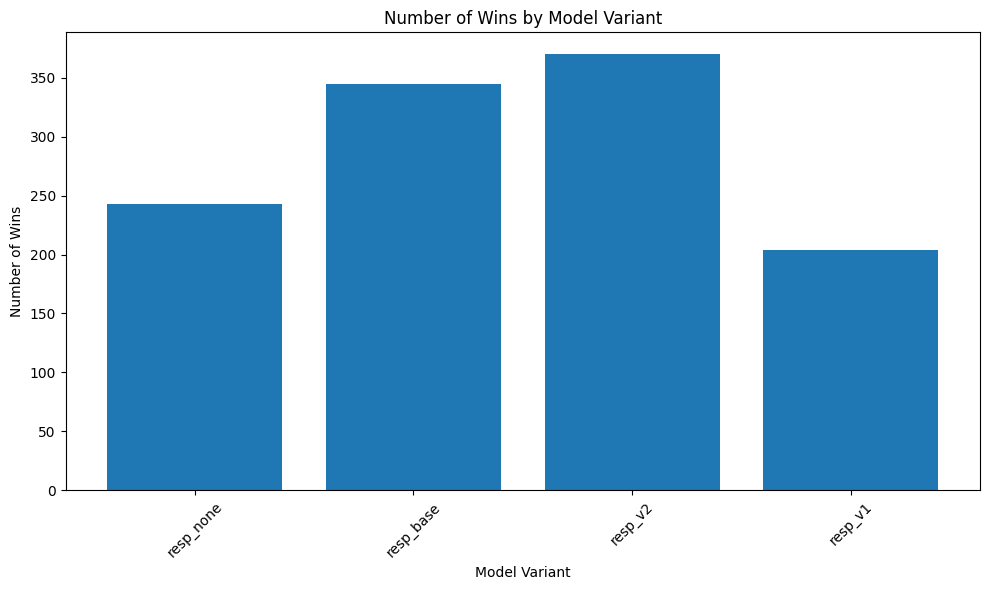

In [20]:
# Read and process pairwise results
pairwise_df = pd.read_csv('pairwise_results.csv')

# Count wins for each variant
variant_wins = {}
for _, row in pairwise_df.iterrows():
    if row['choice'] == 'A':
        winner = row['variant_a']
    elif row['choice'] == 'B':
        winner = row['variant_b']
    else:
        continue
        
    variant_wins[winner] = variant_wins.get(winner, 0) + 1

# Create bar chart
plt.figure(figsize=(10, 6))
variants = list(variant_wins.keys())
wins = list(variant_wins.values())

plt.bar(variants, wins)
plt.title('Number of Wins by Model Variant')
plt.xlabel('Model Variant')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()